In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import json
pi = np.pi

# Затухающий маятник

In [3]:
def get_data(x, v, g, w, type, L, dx):
    config = {
        'model' : type,
        'initial coordinate' : x,
        'initial velocity' : v,
        'attenuation constant' : g,
        'fundamental frequency' : w,
        'modeling interspace' : L,
        'step of modeling' : dx,
        'write' : True,
        'print level' : 0
    }
    write = open('config_file.json', 'w')
    json.dump(config, write, indent=4)
    write.close()
    returned = subprocess.check_output('m.exe')
    return pd.DataFrame(np.fromfile('modeled_data.binary', dtype=np.dtype([
            ('x', np.float64), 
            ("v", np.float64), 
        ])))

## Пример выполнения программы

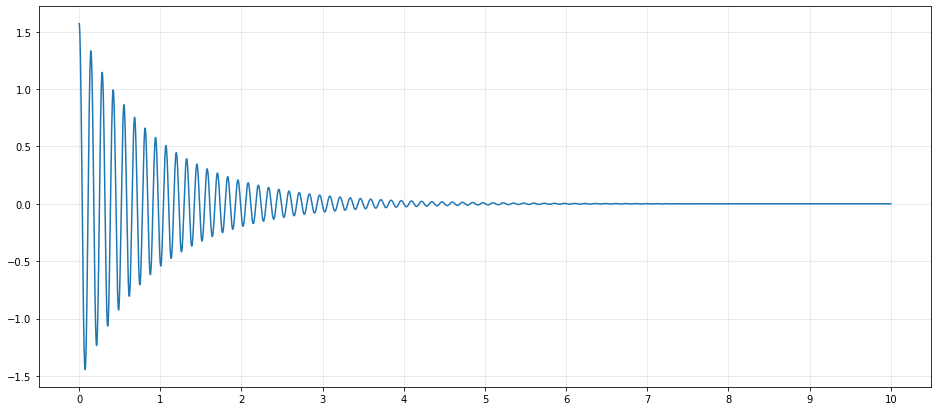

In [127]:
d = get_data(x=pi/2, v=0, g=1, w=50, type='rk', L=10, dx=0.001)
t = np.linspace(0, 10, len(d))

fig, ax = plt.subplots()
fig.set_size_inches(16,7)
ax.plot(t, d.x)

ax.grid(True, alpha=0.3)
ax.set_xticks(np.arange(0,11,1))
plt.show()

## Исследование решений

Уравнение, которое здесь рассматривается
$$x''+2 \gamma x' + \omega^2 \sin(x) = 0$$

На картинке ниже представлены решения для различных параметров $\gamma$ и начального отклонения (частота фиксирована).

Видно, что при увеличении вязкости системы колебания быстрее затухают. Можно выделить три различных вида решений:
1. Затухающие негармонические колебания. Область применимости примерно $\gamma < \omega$. Начальные условия влияют только на 
масштабирование колебаний, но не влияет на вид колебаний (начальное отклонение варьировалось от $\frac{\pi}{n}$ до $\frac{(n-1)\pi}{n}$).  
(Первые 5 рядов, $\gamma \leqslant 5$)
1. Апериодические колебания. Область применимости примерно $\gamma > \omega$.  
(Последний ряд, $\gamma = 6$)
1. Критический режим, являющийся переходом между колебательным и апериодическим режимом. Такой режим должен достигаться при  
$\gamma \approx \omega$ и разделять два предыдущих режима, но в реальном эксперименте достигнут быть не может из-за конечной точности измерений.  
(Предпоследний ряд, $\gamma = 7$)

In [125]:
gamma_N, angle_N = 7, 5      # Параметры, определяющие количество графиков
gamma_low, gamma_high = 1, 7
omega = 6

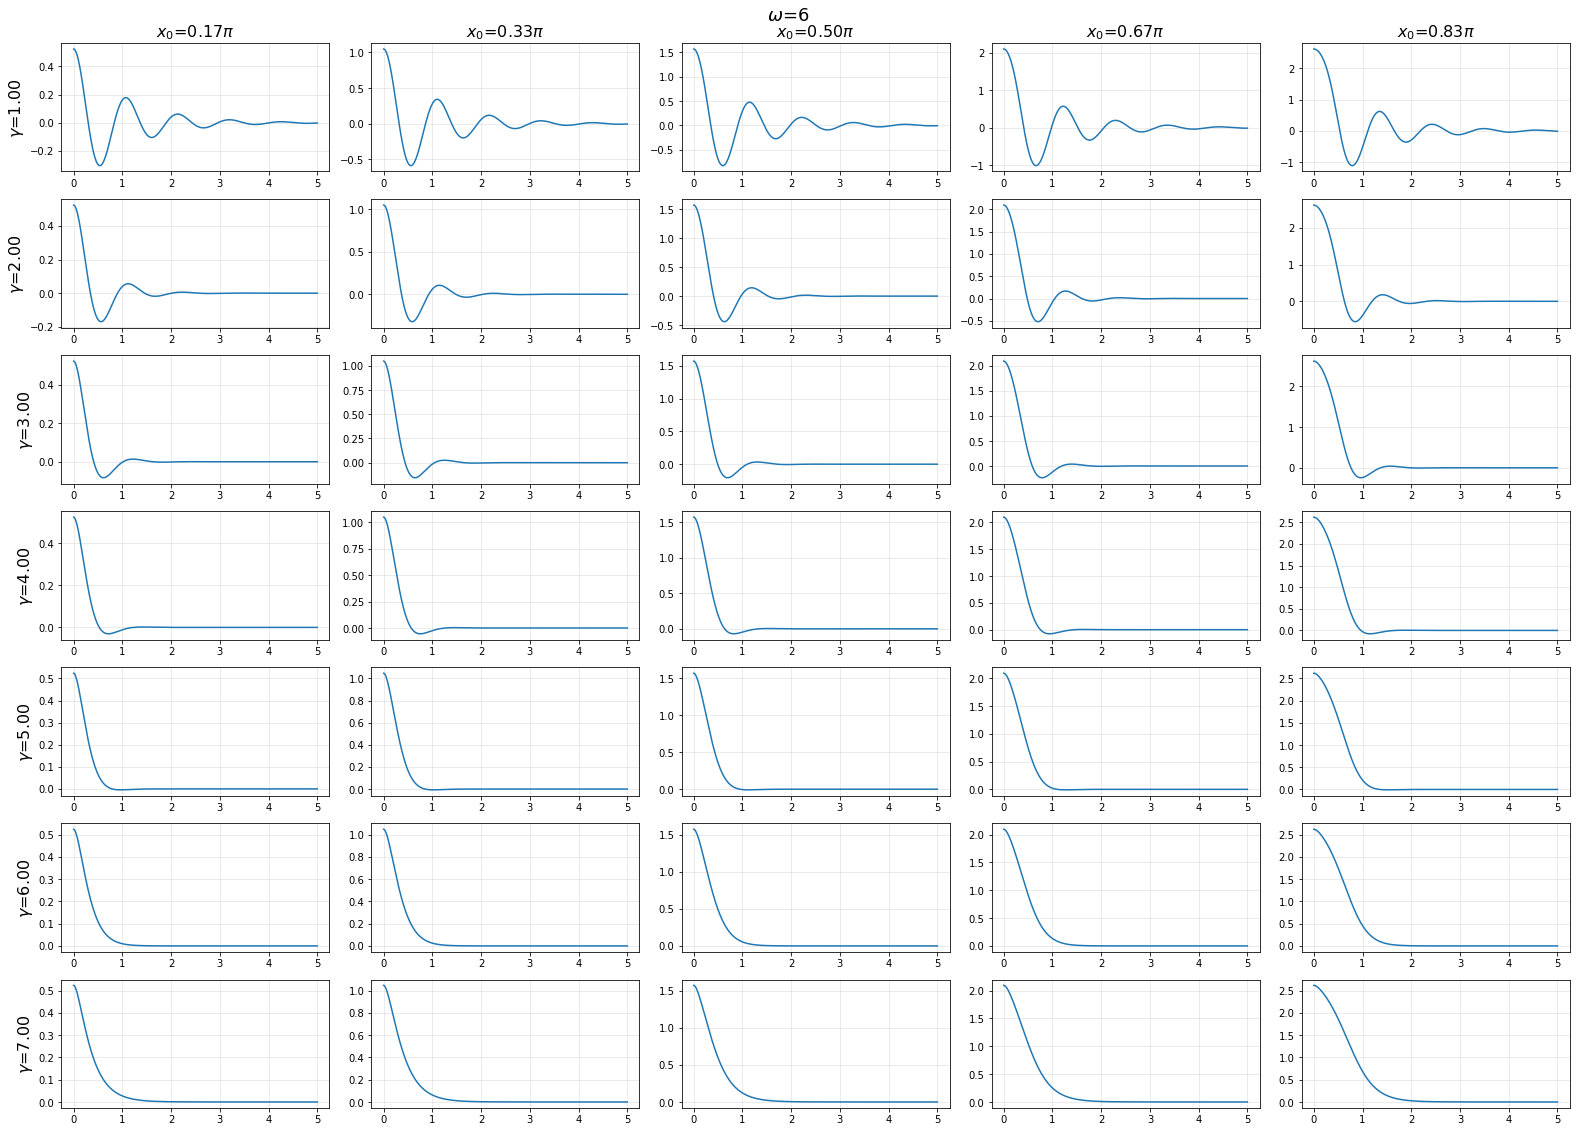

In [126]:
fig, ax = plt.subplots(gamma_N, angle_N)
fig.set_size_inches(22,16)

gamma_arr = np.linspace(gamma_low, gamma_high, gamma_N)
angle_arr = np.array([i * pi / (angle_N+1) for i in range(1, angle_N+1, 1)])

for i, j in ((x,y) for x in range(gamma_N) for y in range(angle_N)):
    d = get_data(x=angle_arr[j], v=0, g=gamma_arr[i], w=omega, type='rk', L=5, dx=0.001)
    t = np.linspace(0, 5, len(d))
    ax[i][j].plot(t, d.x)
    ax[i][j].grid(True, alpha=0.3)
    ax[i][j].set_xticks(range(0,6,1))

fig.suptitle(f'$\omega$={omega}', fontsize=18)
for i in range(gamma_N):
    ax[i][0].set_ylabel(f'$\gamma$={gamma_arr[i]:.2f}', fontsize=16)
for j in range(angle_N):
    ax[0][j].set_title(f'$x_0$={angle_arr[j]/pi:.2f}$\pi$', fontsize=16)

plt.tight_layout()
plt.show()

## Энергия

На картинке ниже представлены графики энергии систем (ось OY - удельная энергия в логарифмическом масштабе, OX - время).  

При достижении порога в $10^{-16}$ Энергия резко падает до 0 (уходит на $-\infty$ в логарифмическом масштабе), что можно объяснить  
точностью типа `double` в C++, точность которого как раз ограничена 16-ым порядком.  

На данных графиках еще отчетливее видно критическое состояние при $\gamma = \omega$. Характер графика в данном случае сначала  
выглядит как один всплеск подобный тем, что периодически появляются при меньшей вязкости, но потом он асимптотически  
выходит на линию. Данные всплески можно объяснить тем, что при малых скоростях теряется меньше энергии и график энергии  
выходит на горизонтальную прямую.

При больших значениях параметра в графике еще отчетливее видна линейная асимптотика, что свидетельствует а другой природе движения.

In [167]:
def En(data, omega):
    return ((0.5 / omega ** 2) * data.v ** 2 + 1 - np.cos(data.x)) / ((0.5 / omega) * data.v[0] ** 2 + 1 - np.cos(data.x[0]))

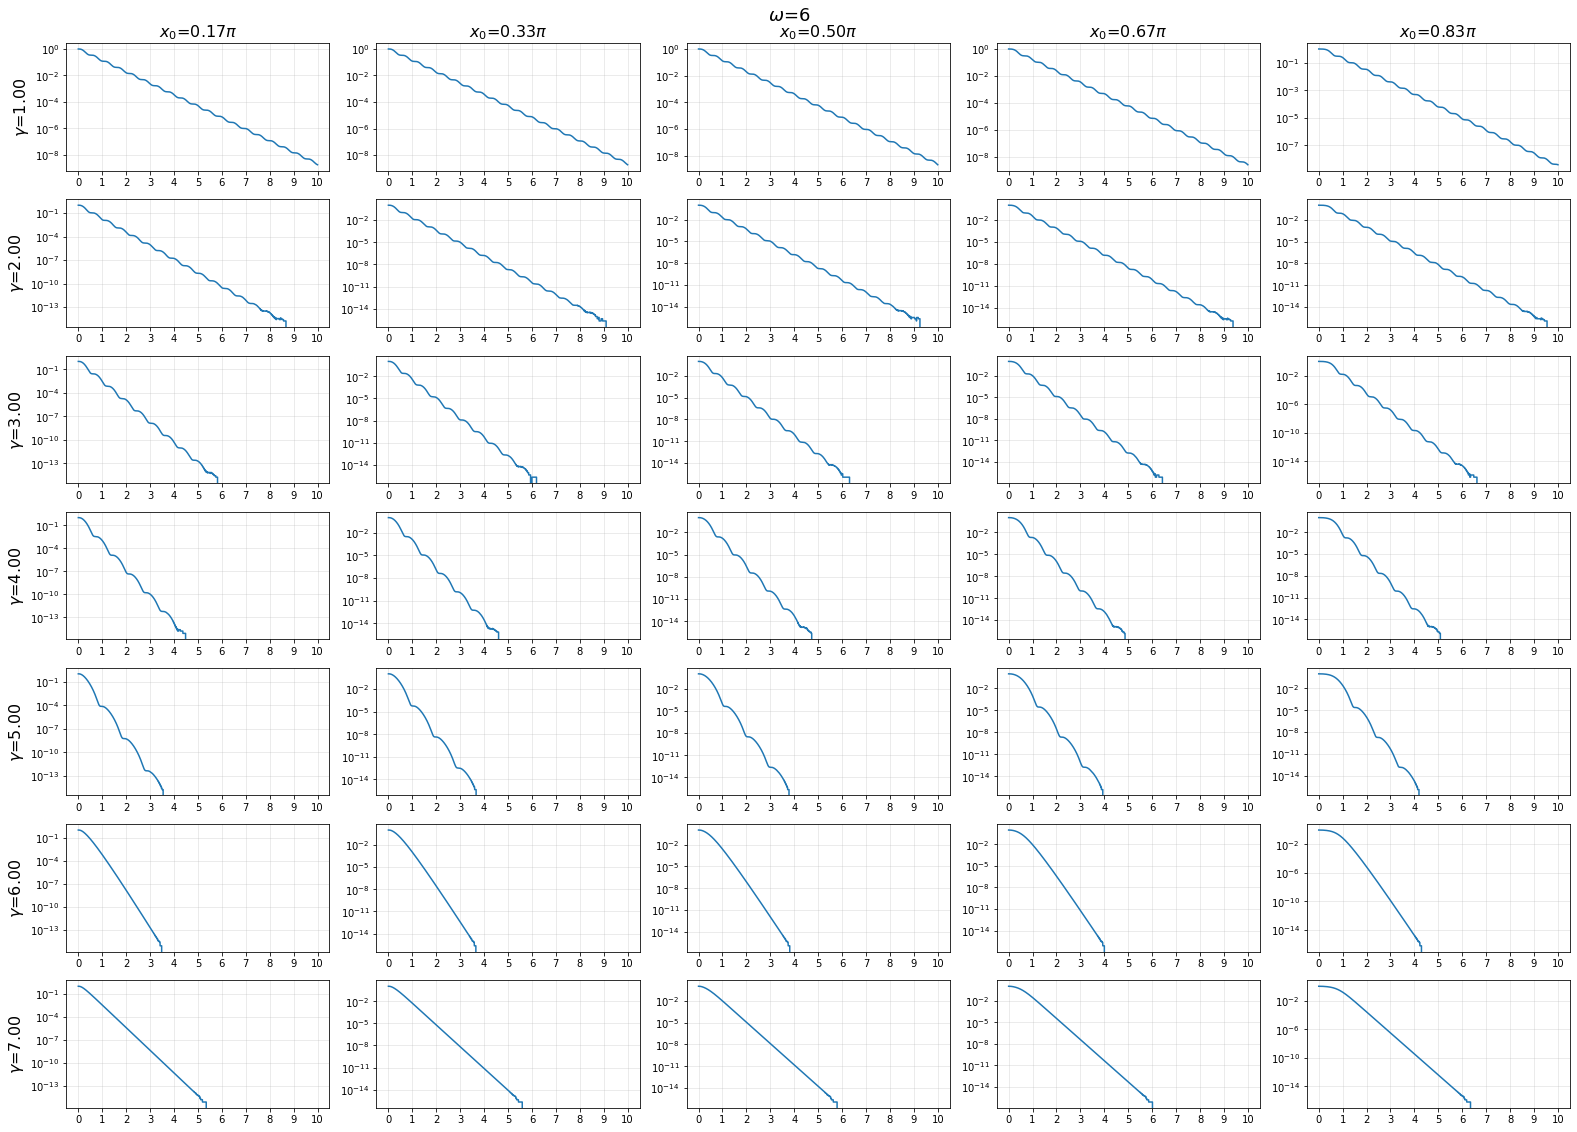

In [168]:
fig, ax = plt.subplots(gamma_N, angle_N)
fig.set_size_inches(22,16)

gamma_arr = np.linspace(gamma_low, gamma_high, gamma_N)
angle_arr = np.array([i * pi / (angle_N+1) for i in range(1, angle_N+1, 1)])

for i, j in ((x,y) for x in range(gamma_N) for y in range(angle_N)):
    d = get_data(x=angle_arr[j], v=0, g=gamma_arr[i], w=omega, type='rk', L=10, dx=0.001)
    t = np.linspace(0, 10, len(d))
    ax[i][j].plot(t, En(d, omega))
    ax[i][j].grid(True, alpha=0.3)
    ax[i][j].set_xticks(range(0,11,1))

    #ax[i][j].set_xscale('log')
    ax[i][j].set_yscale('log')

fig.suptitle(f'$\omega$={omega}', fontsize=18)
for i in range(gamma_N):
    ax[i][0].set_ylabel(f'$\gamma$={gamma_arr[i]:.2f}', fontsize=16)
for j in range(angle_N):
    ax[0][j].set_title(f'$x_0$={angle_arr[j]/pi:.2f}$\pi$', fontsize=16)

plt.tight_layout()
plt.show()

## Добротность системы

Для оценки добротности можно воспользоваться общей формулой
$$Q = 2\pi\dfrac{W_0}{W_{\text{пот}}},$$
где $W_0$ - начальная энергия, $W_{\text{пот}}$ - энергия потерь за период (берется в рассчет первый период).  

На рисунке ниже видно, что при увеличении вязкости $\gamma$ добротность падает экспененциально и чем меньше угол отклонения,  
тем выше добротность (отличие на констатнтый множитель множитель).

In [174]:
def find_first_max(data):
    for i in range(1, len(data)-1, 1):
        if (data.x[i] >= data.x[i-1] and data.x[i] >= data.x[i+1]):
            return i
    else: return -1

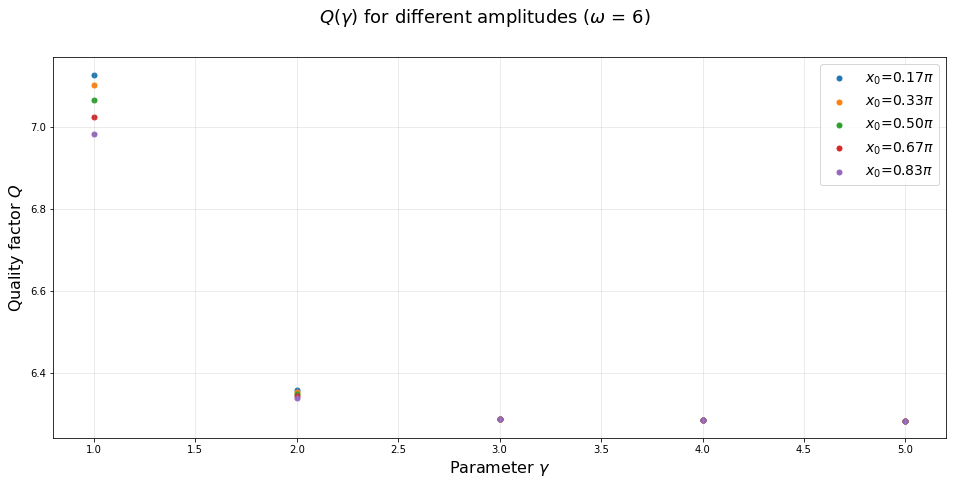

In [198]:
fig, ax = plt.subplots()
fig.set_size_inches(16,7)
fig.suptitle(f'$Q(\gamma)$ for different amplitudes ($\omega$ = {omega})', fontsize=18)

gamma_arr = np.linspace(gamma_low, gamma_high, gamma_N)
angle_arr = np.array([i * pi / (angle_N+1) for i in range(1, angle_N+1, 1)])

for i in range(angle_N):
    f = []
    for j in range(gamma_N):
        d = get_data(x=angle_arr[i], v=0, g=gamma_arr[j], w=omega, type='rk', L=10, dx=0.001)
        idx = find_first_max(d)
        E = En(d, omega)
        f.append(2*pi * E[0] / (E[0]-E[idx]) if idx != -1 else None)
    ax.scatter(gamma_arr, f, s=25, label=f'$x_0$={angle_arr[i]/pi:.2f}$\pi$')

ax.set_xticks(np.arange(1,5.5,0.5))
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=14)
ax.set_xlabel('Parameter $\gamma$', fontsize=16)
ax.set_ylabel('Quality factor $Q$', fontsize=16)
plt.show()